# Benchmarking on LiDAR dataset
    - Argoverse, Nuscenes, Waymo multi-frame

In [1]:
# Imports
import os

os.chdir('/home/vacekpa2/4D-RNSFP')
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from data.dataloader import SFDataset4D, NSF_dataset
from models.RSNF import RigidNeuralPrior, NeuralPrior
from loss.flow import *
from ops.metric import SceneFlowMetric
from vis.deprecated_vis import imshow, visualize_flow3d

from time import time


In [38]:
### Main training loop
# to config?

# This reloads module for development. Nice!
# It reloads all modules after
%load_ext autoreload
%autoreload 2

# from benchmark.exp_config import toy_exp_list
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload
from models.RSNF import * #RigidNeuralPrior, NeuralPrior, FreespaceRigidNeuralPrior


# todo setup everything with ground truth info to know if that helps []
# todo sceneflow metric for multiple runs []
device = torch.device('cuda:0')
 
    
# model_name = 'FastNNNeuralPrior'
# model_name = 'NeuralPrior'
    
model = getattr(sys.modules[__name__], model_name)(lr=0.008, early_stop=100, loss_diff=0.001, dim_x=3, filter_size=128, layer_size=8).to(device)

SF_metric = SceneFlowMetric()  

# dataset = SFDataset4D(**exp_config)
dataset = NSF_dataset(root_dir='/mnt/personal/vacekpa2/sceneflow/', dataset_type='waymo')


for frame_id in tqdm(range(len(dataset))):
    
    # data = dataset.__getitem__(frame_id)   
    data = dataset.__next__()
    
    data['pc1'] = data['pc1'].to(device)
    data['pc2'] = data['pc2'].to(device)
    data['gt_flow'] = data['gt_flow'].to(device)
    # data['relative_pose']
    # data['pose1']
    # data['pose2']
    model.initialize()    
        
    start_time = time()
    output = model(data)
    end_time = time()
    data['eval_time'] = end_time - start_time
    
    pred_flow = output['pred_flow']
    
    # After    
    
    SF_metric.update(data)    
    
    # if frame_id == 0: break    


print(SF_metric.get_metric().mean())


# visualize_flow3d(data['pc1'][0], data['pc2'][0], pred_flow[0])
del model
with torch.no_grad():
    torch.cuda.empty_cache()

[autoreload of data.dataloader failed: Traceback (most recent call last):
  File "/mnt/appl/software/IPython/8.5.0-GCCcore-11.3.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/appl/software/IPython/8.5.0-GCCcore-11.3.0/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/mnt/appl/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/vacekpa2/4D-RNSFP/data/dataloader.py", line 7, in <module>
    from data.path_utils import rel_poses2traj
  File "/home/vacekpa2/4D-RNSFP/data/path_utils.py", line 4, in <module>
    from ops.t

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  1%|          | 2/202 [00:02<04:51,  1.46s/it]

KeyboardInterrupt



In [36]:
df = SF_metric.get_metric()
df[df['EPE'] < 4].mean()


EPE           0.286
AS           46.705
AR           70.229
Angle         0.612
Out           0.412
Eval_Time     1.194
dtype: float64

In [3]:
# The following to latex table if problems
# str_print = ''
# str_print = f'{exp_folder} & '
# for k in results_dict:
#     str_print += f'{result_df[k].mean():.3f} \u00B1 {result_df[k].std():.3f} & '
# str_print = str_print[:-2]# load metric, make plot
# cat df
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vis.deprecated_vis import imshow
# todo transfer file from scripts to server



search_dir = "/mnt/personal/vacekpa2/experiments/4D-RNSFP/"
files = [p for p in (glob.glob(search_dir + "*")) if not p.startswith('dev')]  
files.sort(key=lambda x: os.path.getmtime(x))
# experiments = [os.path.basename(f) for f in files]

experiments = ['NeuralPrior', 'RigidNeuralPriorV2']
exp_dataframes = []


for exp_folder in experiments:
    
    metric_files = sorted(glob.glob(f'/mnt/personal/vacekpa2/experiments/4D-RNSFP/{exp_folder}/metric-*.csv'))
    loaded_dfs = [pd.read_csv(f, index_col=0) for f in metric_files]

    # metric_dict = {k : [] for k in loaded_dfs[0].columns}
    exp_dataframes.append(loaded_dfs)
    

# dataset_dict = {}

# plt.close()
# plt.grid()
# plt.title("EPE comparison")
# plt.xlabel("Models")
# plt.ylabel("EPE [m]")

# for i, exp in enumerate(experiments):
#     print(exp_dataframes[0])
#     epe = exp_dataframes[i]['EPE'].mean()
#     std = exp_dataframes[i]['EPE'].std()
#     plt.errorbar(exp, epe, yerr=std, fmt='o')

# imshow(fig=plt)



# The following to latex table if problems
# str_print = ''
# str_print = f'{exp_folder} & '
# for k in results_dict:
#     str_print += f'{result_df[k].mean():.3f} \u00B1 {result_df[k].std():.3f} & '


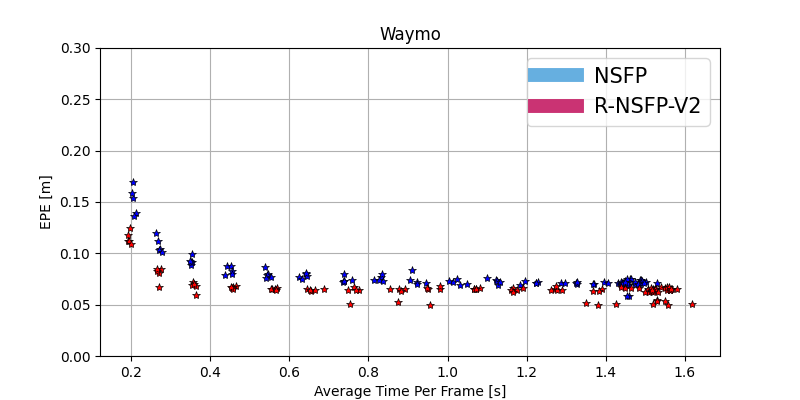

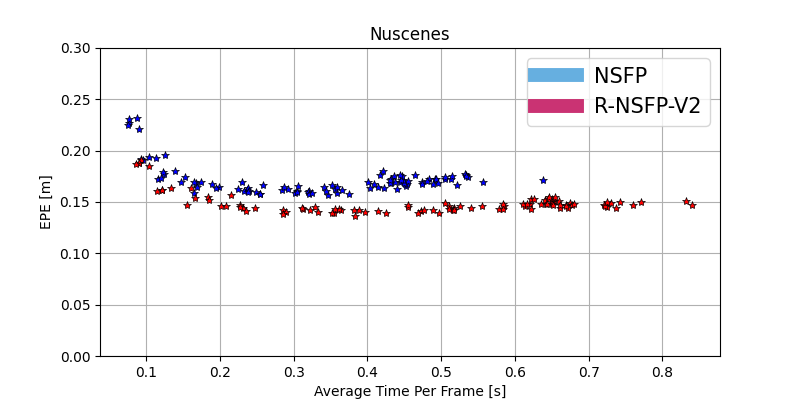

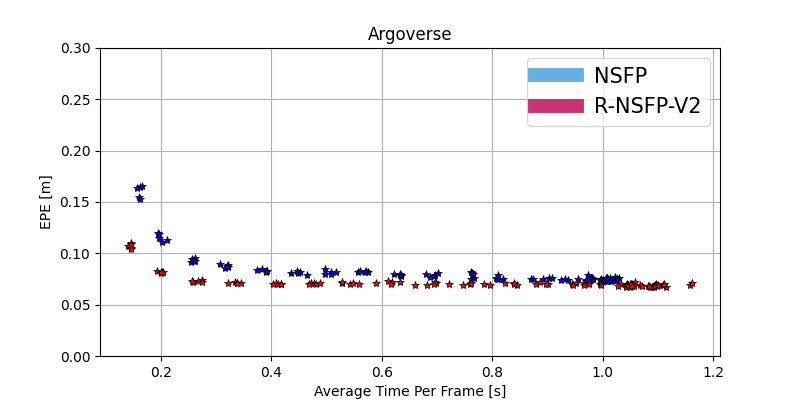

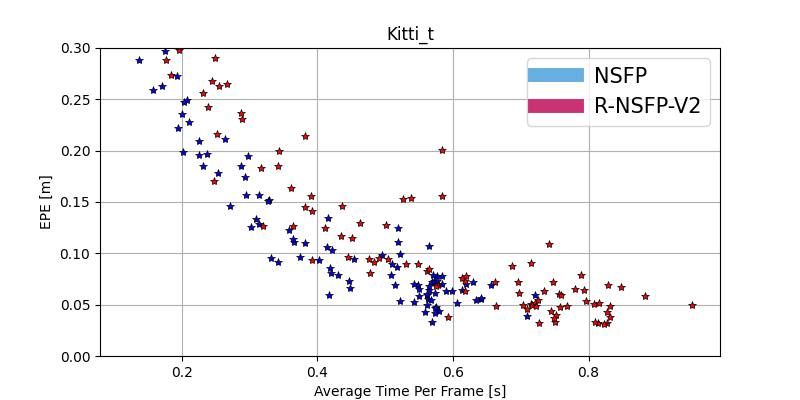

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vis.deprecated_vis import imshow

# todo, more metric visuals
# todo how to iterate datasets? - function of dataset_type
plt.close()
plt.cla()



def setup_metric_figures(dataset_type='waymo'):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    ax = [ax]
    ax[0].set_title(dataset_type.capitalize())
    ax[0].grid(True)  
    # ax[1].grid(True)  
    ax[0].set_xlabel("Average Time Per Frame [s]")
    # ax[1].set_xlabel("Early stop parameter")
    ax[0].set_ylabel("EPE [m]")
    ax[0].set_ylim([0, 0.3])
    # ax[1].set_ylabel("EPE [m]")
    # ax[1].set_title('We have smaller std - good?; Ours artificialy shifted to right so ther are visible')
    # ax[1].set_title('We have smaller std - good?')
    
    baseArtist = plt.Line2D((0,1),(0,0), color='#007acc', alpha=0.6, linewidth=10)
    oursArtist = plt.Line2D((0,1),(0,0), color='#BD0050', alpha=0.8, linewidth=10)
    # oursV2Artist = plt.Line2D((0,1),(0,0), color='#00BD50', alpha=0.8, linewidth=10)
    
    ax[0].legend([baseArtist, oursArtist], ['NSFP', 'R-NSFP-V2'], loc='upper right', fontsize=15)

    return fig, ax


experiments = ['NeuralPrior', 'RigidNeuralPriorV2']
dataset_types = ['waymo', 'nuscenes', 'argoverse', 'kitti_t']

# other metric bars?

    
for dataset_type in dataset_types:
    
    fig, ax = setup_metric_figures(dataset_type=dataset_type)
    
    for i, exp_folder in enumerate(experiments):        
        
        metric_files = sorted(glob.glob(f'/mnt/personal/vacekpa2/experiments/4D-RNSFP/{exp_folder}/{dataset_type}/metric-*.csv'))
        
        loaded_dfs = [pd.read_csv(f, index_col=0) for f in metric_files]
        
        epe_list = []
        time_list = []
        
        for df in loaded_dfs:
            mask = df["EPE"] < 3
            epe = df['EPE'][mask].mean()
            epe_list.append(epe)
            time_list.append(df['Eval_Time'][mask].mean())
        
              
        if i == 0:
            ax[0].plot(time_list, epe_list, 'b*', markersize=6, mec='black', mew=0.5)    
        if i == 1:
            ax[0].plot(time_list, epe_list, 'r*', markersize=6, mec='black', mew=0.5)
        if i == 2:
            ax[0].plot(time_list, epe_list, 'g.', markersize=6)
        
    imshow(fig)
    plt.close()

# for i, loaded_dfs in enumerate(exp_dataframes):
#     # todo what is with std visuals?
#     epe_list = []
#     time_list = []
#     for j in range(len(loaded_dfs)):
#         df = loaded_dfs[j]
#         mask = df["EPE"] < 100
#         epe = df['EPE'][mask].mean()
#         
#         epe_list.append(epe)
#         time_list.append(df['Eval_Time'][mask].mean())
#     
#         if j % 5 == 0:
#             epe_mean = np.array(epe_list).mean()
#             epe_std = np.array(epe_list).std()  
#             time_mean = np.array(time_list).mean()
#             early_stop = j * 2
#             if i == 0:
#                 # ax[1].errorbar(early_stop, epe_mean, epe_std, fmt='-o', color='#007acc', marker='o', capsize=3)    
#                 ax[1].errorbar(time_mean, epe_mean, epe_std, fmt='-o', color='#007acc', capsize=3)    
#             if i == 1:
#                 # ax[1].errorbar(early_stop + 3, epe_mean, epe_std, fmt='-o', color='#BD0050', marker='o', capsize=3)
#                 ax[1].errorbar(time_mean, epe_mean, epe_std, fmt='-o', color='#BD0050', capsize=3)
#             if i == 2:
#                 ax[1].errorbar(time_mean, epe_mean, epe_std, fmt='-o', color='#00BD50', capsize=3)
#                 
#             epe_list = []
#             time_list = []
#     
# 
#   fig.savefig('/home/vacekpa2/4D-RNSFP/paper/exp_results/NP-vs-RNPv1.0.png', dpi=300, bbox_inches='tight')
# imshow(fig)


# Contribution
##### 1) Introducing sequentialness of the data into SceneFlow
##### 2) Introducing concept of Freespace as loss to SceneFlow
##### 3) Introducing Global Map as correspondence improvement to SceneFlow
##### 4) Introducing Ego-Kinematic as loss to SceneFlow
##### Optional) Proposing Efficient computation of K-NN for real-time (Not sure, will see how it goes when implementing cyclic smoothness to 4D) 

&nbsp;
&nbsp;
# Main SOTA Baseline
##### FastNeuralPrior - realtime NeuralPrior
 